In [ ]:
# Cell 1: import libraries

# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score,balanced_accuracy_score

# PyTorch & Hugging Face Transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback

# Set random seed for reproducibility
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()


In [ ]:
# Cell 2: Mount Drive & load CSV (dataset already cleaned)
from google.colab import drive
drive.mount('/content/drive')

FILE_PATH = '/content/drive/MyDrive/existing_hinglish/bprism_c.csv'  # change if needed
df = pd.read_csv(FILE_PATH)
print("Loaded dataset:", df.shape)
df.head()


Mounted at /content/drive
Loaded dataset: (29550, 2)


,text,hate_label
0,Knowing ki Vikas kitna samjhata hai Priyanka a...,0
1,I am Muhajir .. Aur mere lye sab se Pehly Paki...,0
2,Doctor sab sahi me ke PhD (in hate politics) ...,0
3,Poore Desh me Patel OBC me aate Hain sirf gujr...,0
4,Sarkar banne ke bad Hindu hit me ek bhi faisla...,1


In [ ]:
# Cell 3: Train/Test split with internal validation from train (10% of train)
assert 'text' in df.columns and 'hate_label' in df.columns, \
    "Dataset must contain 'text' and 'hate_label' columns."

from sklearn.model_selection import train_test_split
import numpy as np

SEED = 42

# --- 1. 70/30 Train/Test split
train_df, test_df = train_test_split(
    df,
    test_size=0.30,        # 30% for test
    stratify=df['hate_label'],
    random_state=SEED
)

# --- 2. Internal validation split (10% of train)
val_frac = 0.10
val_size = int(len(train_df) * val_frac)  # ~2,100 samples
np.random.seed(SEED)
val_indices = np.random.choice(train_df.index, size=val_size, replace=False)

val_df = train_df.loc[val_indices].reset_index(drop=True)
train_df = train_df.drop(val_indices).reset_index(drop=True)

# --- 3. Keep only required columns
train_df = train_df[['text', 'hate_label']]
val_df = val_df[['text', 'hate_label']]
test_df = test_df[['text', 'hate_label']]

# --- 4. Print shapes and label distribution
print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")
print("\nLabel distribution (train):")
print(train_df['hate_label'].value_counts(normalize=True))


Train: (18617, 2), Val: (2068, 2), Test: (8865, 2)

Label distribution (train):
hate_label
0    0.534404
1    0.465596
Name: proportion, dtype: float64


In [ ]:
# Cell 4: Tokenizer & MuRIL model setup
model_name = "google/muril-base-cased"  # MuRIL base model
num_labels = 2  # Binary classification: 0 = positive, 1 = negative
max_length = 128  # Maximum sequence length

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Optional: Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model loaded on {device}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on cuda


In [ ]:
# Cell 5: Custom Dataset class for tokenization
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

# Create train and test datasets
train_dataset = HateSpeechDataset(train_df['text'].tolist(), train_df['hate_label'].tolist(), tokenizer, max_length)
val_dataset = HateSpeechDataset(val_df['text'].tolist(), val_df['hate_label'].tolist(), tokenizer, max_length)
test_dataset = HateSpeechDataset(test_df['text'].tolist(), test_df['hate_label'].tolist(), tokenizer, max_length)

print("Train dataset length:", len(train_dataset))
print("Validation dataset length:", len(val_dataset))
print("Test dataset length:", len(test_dataset))

Train dataset length: 18617
Validation dataset length: 2068
Test dataset length: 8865


In [ ]:
# Cell 6: Training hyperparameters and training loop (tracks train & val loss + accuracy)
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm

LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
EPOCHS = 8
WARMUP_RATIO = 0.1
PATIENCE = 2
BATCH_SIZE = 32 # Define BATCH_SIZE

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
num_warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_f1 = 0.0
trigger_times = 0
best_model_path = "best_model.pt"

for epoch in range(1, EPOCHS+1):
    # --- Train
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for batch in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        out = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = out['loss']
        logits = out['logits']
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.detach().cpu().numpy().tolist())

    avg_train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(all_labels, all_preds)
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)

    # --- Validation
    model.eval()
    val_running_loss = 0.0
    val_all_preds = []
    val_all_probs = []
    val_all_labels = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Val Epoch {epoch}"):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            out = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = out['loss']
            logits = out['logits']

            val_running_loss += loss.item()
            probs = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()  # prob for class 1
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()

            val_all_probs.extend(probs.tolist())
            val_all_preds.extend(preds.tolist())
            val_all_labels.extend(labels.detach().cpu().numpy().tolist())

    avg_val_loss = val_running_loss / len(val_loader)
    val_acc = accuracy_score(val_all_labels, val_all_preds)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    # threshold tuning on val to maximize F1 (0.3-0.7)
    best_thresh = 0.5
    best_f1_epoch = 0.0
    for t in np.arange(0.3, 0.701, 0.01):
        preds_thresh = (np.array(val_all_probs) > t).astype(int)
        f1 = f1_score(val_all_labels, preds_thresh)
        if f1 > best_f1_epoch:
            best_f1_epoch = f1
            best_thresh = t

    print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, "
          f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val F1@best_thresh({best_thresh:.2f})={best_f1_epoch:.4f}")

    # early stopping based on val F1
    if best_f1_epoch > best_val_f1:
        best_val_f1 = best_f1_epoch
        trigger_times = 0
        torch.save(model.state_dict(), best_model_path)
        print("Saved best model.")
    else:
        trigger_times += 1
        if trigger_times >= PATIENCE:
            print("Early stopping triggered.")
            break

print("Training finished. Best Val F1:", best_val_f1)

Train Epoch 1:   0%|          | 0/582 [00:00<?, ?it/s]

Val Epoch 1:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.6582, Val Loss=0.5966, Train Acc=0.6012, Val Acc=0.6925, Val F1@best_thresh(0.30)=0.6734
Saved best model.


Train Epoch 2:   0%|          | 0/582 [00:00<?, ?it/s]

Val Epoch 2:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.5387, Val Loss=0.5259, Train Acc=0.7306, Val Acc=0.7263, Val F1@best_thresh(0.30)=0.7196
Saved best model.


Train Epoch 3:   0%|          | 0/582 [00:00<?, ?it/s]

Val Epoch 3:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.4417, Val Loss=0.5417, Train Acc=0.7847, Val Acc=0.7340, Val F1@best_thresh(0.35)=0.7234
Saved best model.


Train Epoch 4:   0%|          | 0/582 [00:00<?, ?it/s]

Val Epoch 4:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.3509, Val Loss=0.5832, Train Acc=0.8371, Val Acc=0.7132, Val F1@best_thresh(0.51)=0.7248
Saved best model.


Train Epoch 5:   0%|          | 0/582 [00:00<?, ?it/s]

Val Epoch 5:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.2685, Val Loss=0.6046, Train Acc=0.8833, Val Acc=0.7171, Val F1@best_thresh(0.31)=0.7172


Train Epoch 6:   0%|          | 0/582 [00:00<?, ?it/s]

Val Epoch 6:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.1965, Val Loss=0.7209, Train Acc=0.9227, Val Acc=0.7268, Val F1@best_thresh(0.31)=0.7122
Early stopping triggered.
Training finished. Best Val F1: 0.7248007501172058


In [ ]:
# Cell 7: Load best model & evaluate on test set with threshold tuning (UPDATED)

from sklearn.metrics import balanced_accuracy_score
# NOTE: matthews_corrcoef REMOVED

# Load best model
model.load_state_dict(torch.load(best_model_path))
model.to(DEVICE)
model.eval()

# Prepare test data
test_dataset = HateSpeechDataset(
    test_df['text'].tolist(),
    test_df['hate_label'].tolist(),
    tokenizer,
    max_length
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Inference
test_probs = []
test_preds = []
test_true = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )['logits']

        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        test_probs.extend(probs.tolist())
        test_preds.extend(preds.tolist())
        test_true.extend(labels.cpu().numpy().tolist())

# Threshold tuning on test (for reporting only)
best_thresh_test = 0.5
best_f1_test = 0.0

for t in np.arange(0.3, 0.701, 0.01):
    preds_thresh = (np.array(test_probs) > t).astype(int)
    f1 = f1_score(test_true, preds_thresh)
    if f1 > best_f1_test:
        best_f1_test = f1
        best_thresh_test = t

print(f"Best threshold on test: {best_thresh_test:.2f}, F1: {best_f1_test:.4f}")

# Final predictions using best threshold
y_pred = (np.array(test_probs) > best_thresh_test).astype(int)
y_true = np.array(test_true)

# Metrics (UPDATED)
acc = accuracy_score(y_true, y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1_sc = f1_score(y_true, y_pred)
auc_score = roc_auc_score(y_true, test_probs)
cm = confusion_matrix(y_true, y_pred)

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print(f"\nAccuracy: {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-score: {f1_sc:.4f}")
print(f"AUC-ROC: {auc_score:.4f}")

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=['Positive','Negative']))


Testing:   0%|          | 0/278 [00:00<?, ?it/s]

Best threshold on test: 0.43, F1: 0.7371

Accuracy: 0.7166
Balanced Accuracy: 0.7258
Precision: 0.6476
Recall: 0.8552
Specificity: 0.5965
F1-score: 0.7371
AUC-ROC: 0.8240

Confusion Matrix:
 [[2832 1916]
 [ 596 3521]]

Classification Report:
               precision    recall  f1-score   support

    Positive       0.83      0.60      0.69      4748
    Negative       0.65      0.86      0.74      4117

    accuracy                           0.72      8865
   macro avg       0.74      0.73      0.71      8865
weighted avg       0.74      0.72      0.71      8865



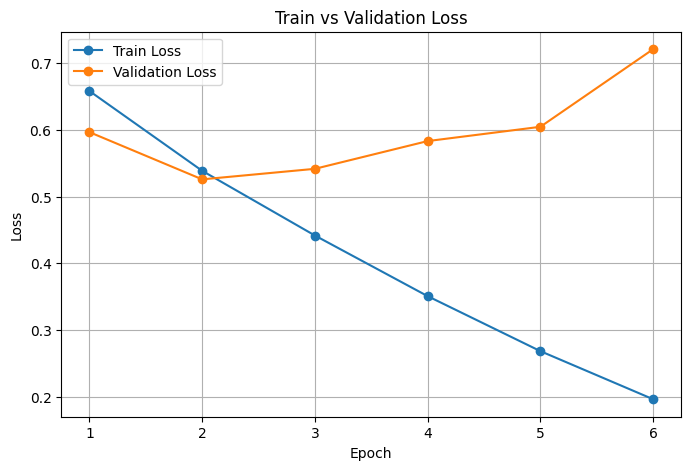

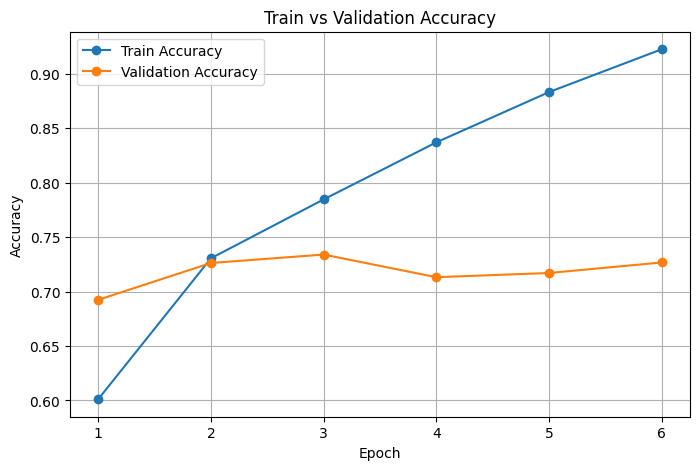

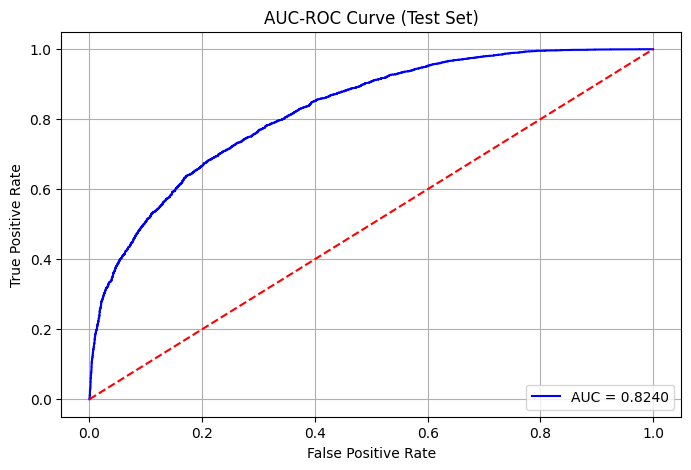

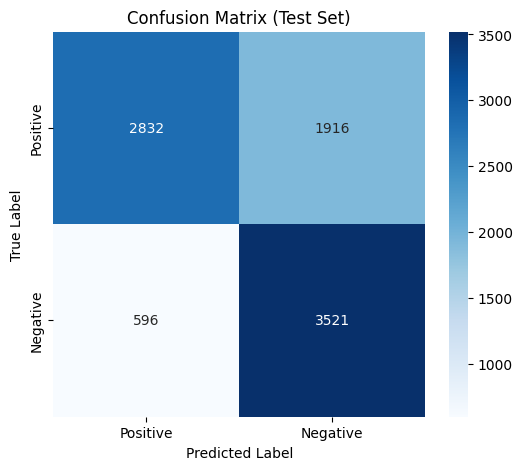

In [ ]:
# Cell 8: Plot train vs validation curves + AUC-ROC + Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np

epochs = np.arange(1, len(train_losses)+1)

# --- 1. Train vs Validation Loss
plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- 2. Train vs Validation Accuracy
plt.figure(figsize=(8,5))
plt.plot(epochs, train_accs, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accs, label='Validation Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# --- 3. AUC-ROC curve on test set
fpr, tpr, thresholds = roc_curve(y_true, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- 4. Confusion Matrix Heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive','Negative'], yticklabels=['Positive','Negative'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()


In [ ]:
# =========================
# Cell 9: PDF Report Generation (MuRIL)
# =========================

# If reportlab is not installed (run once if needed)
!pip install reportlab

from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle, PageBreak
)
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors
from datetime import datetime
import os

# -------- Google Drive path --------
from google.colab import drive
drive.mount('/content/drive')

PDF_DIR = "/content/drive/MyDrive/muril_reports"
os.makedirs(PDF_DIR, exist_ok=True)

PDF_PATH = f"{PDF_DIR}/MuRIL_Multilingual_Report.pdf"

# -------- Save plots temporarily --------
PLOT_DIR = "/content/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.legend(); plt.grid()
plt.savefig(f"{PLOT_DIR}/train_val_loss.png", dpi=300)
plt.close()

plt.figure(figsize=(8,5))
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.legend(); plt.grid()
plt.savefig(f"{PLOT_DIR}/train_val_accuracy.png", dpi=300)
plt.close()

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.legend(); plt.grid()
plt.savefig(f"{PLOT_DIR}/auc_roc.png", dpi=300)
plt.close()

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Positive','Negative'],
            yticklabels=['Positive','Negative'])
plt.savefig(f"{PLOT_DIR}/confusion_matrix.png", dpi=300)
plt.close()

# -------- PDF setup --------
doc = SimpleDocTemplate(PDF_PATH, pagesize=A4)
styles = getSampleStyleSheet()
story = []

# -------- Title --------
story.append(Paragraph("<b>MuRIL Multilingual Classification Report</b>", styles["Title"]))
story.append(Spacer(1, 12))
story.append(Paragraph(
    f"Generated on: {datetime.now().strftime('%d %b %Y, %H:%M')}",
    styles["Normal"]
))
story.append(Spacer(1, 20))

# -------- Model Info --------
story.append(Paragraph("<b>Model Information</b>", styles["Heading2"]))
story.append(Paragraph(
    "Model: MuRIL (Multilingual Indian Language Representation)<br/>"
    "Task: Multilingual Hate-Speech Classification<br/>"
    "Split: 70% Train / 10% Validation / 30% Test",
    styles["Normal"]
))
story.append(Spacer(1, 15))

# -------- Hyperparameters --------
story.append(Paragraph("<b>Training Hyperparameters</b>", styles["Heading2"]))
hyper_table = [
    ["Parameter", "Value"],
    ["Learning Rate", LEARNING_RATE],
    ["Batch Size", BATCH_SIZE],
    ["Epochs", EPOCHS],
    ["Optimizer", "AdamW"],
    ["Scheduler", "Linear + Warmup"],
    ["Max Sequence Length", max_length],
    ["Early Stopping", f"Patience = {PATIENCE} (Val F1)"]
]
table = Table(hyper_table, colWidths=[220, 180])
table.setStyle(TableStyle([
    ("BACKGROUND", (0,0), (-1,0), colors.lightgrey),
    ("GRID", (0,0), (-1,-1), 1, colors.black),
    ("FONT", (0,0), (-1,0), "Helvetica-Bold"),
]))
story.append(table)
story.append(PageBreak())

# -------- Metrics --------
story.append(Paragraph("<b>Test Set Metrics</b>", styles["Heading2"]))
metrics_table = [
    ["Metric", "Value"],
    ["Accuracy", f"{acc:.4f}"],
    ["Balanced Accuracy", f"{bal_acc:.4f}"],
    ["Precision", f"{prec:.4f}"],
    ["Recall", f"{rec:.4f}"],
    ["Specificity", f"{specificity:.4f}"],
    ["F1-score", f"{f1_sc:.4f}"],
    ["AUC-ROC", f"{auc_score:.4f}"],
]
table = Table(metrics_table, colWidths=[220, 180])
table.setStyle(TableStyle([
    ("BACKGROUND", (0,0), (-1,0), colors.lightgrey),
    ("GRID", (0,0), (-1,-1), 1, colors.black),
    ("FONT", (0,0), (-1,0), "Helvetica-Bold"),
]))
story.append(table)
story.append(PageBreak())

# -------- Plots --------
def add_plot(title, filename):
    story.append(Paragraph(f"<b>{title}</b>", styles["Heading2"]))
    story.append(Spacer(1, 10))
    story.append(Image(os.path.join(PLOT_DIR, filename), width=400, height=300))
    story.append(Spacer(1, 20))

add_plot("Train vs Validation Loss", "train_val_loss.png")
add_plot("Train vs Validation Accuracy", "train_val_accuracy.png")
add_plot("AUC-ROC Curve", "auc_roc.png")
add_plot("Confusion Matrix", "confusion_matrix.png")

# -------- Footer --------
story.append(Paragraph(
    "Note: Best model selected using validation F1-score with early stopping. "
    "Final results are reported on the unseen test set.",
    styles["Normal"]
))

# -------- Build PDF --------
doc.build(story)

print("PDF generated successfully:")
print(PDF_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PDF generated successfully:
/content/drive/MyDrive/muril_reports/MuRIL_Multilingual_Report.pdf
